# Load Packages

In [1]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [2]:
# Import packages
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import segmentation_models as sm
sm.set_framework('tf.keras')
from tensorflow.keras.applications import vgg16
from sklearn.metrics import *

2025-12-11 08:08:55.872379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 08:08:56.001444: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 08:08:56.029700: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-11 08:08:56.516783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Configuration
base_dir = r"/root/attention-mechanism-unet-main/LoveDA_Processed/" 

# Functions

In [4]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [5]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [6]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process LoveDA Dataset

In [9]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = training_images_list  # LoveDA: same filename for image and mask
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images and masks (LoveDA has test masks)
test_images_list = os.listdir(r"{}Test/images/".format(base_dir))
test_masks_list = test_images_list
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/images/{}".format(base_dir,n))
  test_images.append(im)

test_masks = []
for n in test_masks_list:
  im = PIL.Image.open(r"{}Test/masks/{}".format(base_dir,n))
  test_masks.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = validation_images_list  # LoveDA: same filename
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [10]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = np.array(training_masks[i])/255.0  # LoveDA: 0/255 -> 0/1
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('float32')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])/255.0  # LoveDA: 0/255 -> 0/1
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('float32')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

for i in range(len(test_masks)):
  test_masks[i] = np.array(test_masks[i])/255.0  # LoveDA: 0/255 -> 0/1
  test_masks[i] = test_masks[i].reshape(1,512,512,1)
  test_masks[i] = test_masks[i].astype('float32')

# LoveDA dataset already split into 70/20/10, no need to reorganize
print(f"Training: {len(training_images)} images")
print(f"Validation: {len(validation_images)} images")
print(f"Test: {len(test_images)} images")

Training: 70 images
Validation: 20 images
Test: 10 images


In [11]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

2025-12-11 08:11:40.524003: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-12-11 08:11:40.525170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 08:11:40.547739: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-12-11 08:13:14.915113: I tensorflow/core/common_runtime/gpu/gpu_d

In [12]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [13]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

# Models

## Attention U-Net

In [14]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [15]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (1, 512, 512, 16)    448         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (1, 512, 512, 16)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (1, 512, 512, 16)    2320        ['activation[0][0]']             
                                                                                              

# Train on RGB feature data

## Attention U-Net

In [16]:
# Train Attention U-Net model

am_unet = UNetAM()
save_model_am = ModelCheckpoint('unet-attention-loveda.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

am_unet.fit(train,
            steps_per_epoch=100,
            epochs=50,
            validation_data=validation_df,
            callbacks=[save_model_am])

Epoch 1/50


2025-12-11 08:16:36.474911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-12-11 08:16:37.156212: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-12-11 08:16:37.156227: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-12-11 08:16:37.156265: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-12-11 08:17:53.973519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 99/100 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.5668 - mse: 0.2482
Epoch 1: val_accuracy improved from -inf to 0.63349, saving model to unet-attention-loveda.hdf5
100/100 [==============================] - 349s 54ms/step - loss: 0.6902 - accuracy: 0.5667 - mse: 0.2482 - val_loss: 0.6522 - val_accuracy: 0.6335 - val_mse: 0.2285
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7731 - mse: 0.1754
Epoch 2: val_accuracy improved from 0.63349 to 0.82152, saving model to unet-attention-loveda.hdf5
100/100 [==============================] - 5s 54ms/step - loss: 0.5319 - accuracy: 0.7731 - mse: 0.1754 - val_loss: 0.4096 - val_accuracy: 0.8215 - val_mse: 0.1286
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.4794 - accuracy: 0.8040 - mse: 0.1510
Epoch 3: val_accuracy improved from 0.82152 to 0.86698, saving model to unet-attention-loveda.hdf5
100/100 [==============================] - 5s 49ms/step -

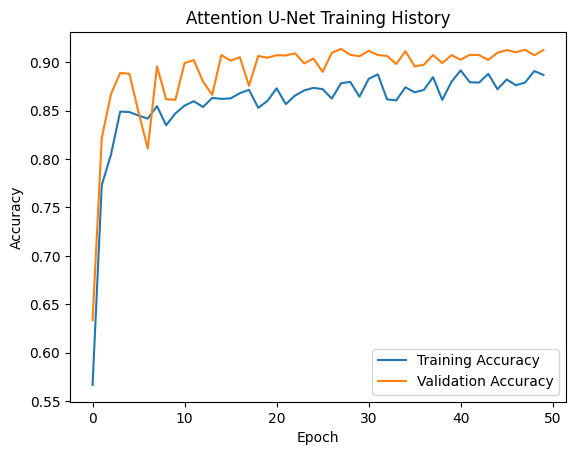

In [17]:
# Plot training history
plt.plot(am_unet.history.history['accuracy'], label='Training Accuracy')
plt.plot(am_unet.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Attention U-Net Training History')
plt.legend()

# Import Models and Compute Metrics

## RGB

In [18]:
# Load trained model
attention_unet = load_model('unet-attention-loveda.hdf5')

In [19]:
# Evaluate on validation data
am_unet_score = score_eval(attention_unet, validation_images, validation_masks)
am_unet_precision = precision_eval(attention_unet, validation_images, validation_masks)
am_unet_recall = recall_eval(attention_unet, validation_images, validation_masks)
am_unet_f1_score = f1_score_eval(attention_unet, validation_images, validation_masks)

1/1 [==============================] - 0s 24ms/step


In [20]:
# Print eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

Attention U-Net accuracy:  0.9136159896850586 0.04965376012195155


In [21]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

Attention U-Net precision:  0.9200785080756363 0.04214630374423351


In [22]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

Attention U-Net recall:  0.9136159896850586 0.04965376012195155


In [23]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

Attention U-Net F1-score:  0.9168358609026883


1/1 [==============================] - 0s 26ms/step


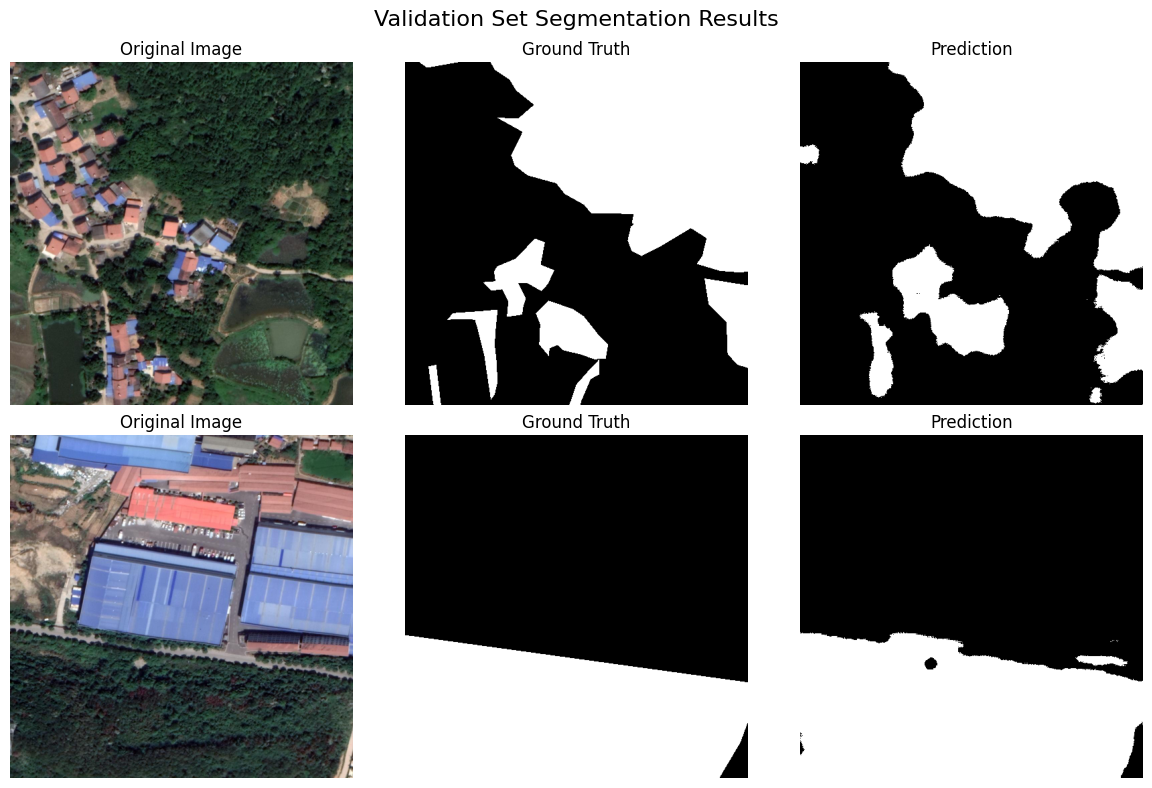

Saved to validation_results.png


In [ ]:
# Visualize segmentation results on validation set
num_samples = min(2, len(validation_images)) 

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    # Get image and masks
    img = validation_images[i].reshape(512, 512, 3)
    true_mask = validation_masks[i].reshape(512, 512)
    
    # Predict
    pred_mask = attention_unet.predict(validation_images[i]).reshape(512, 512)
    pred_mask_binary = np.round(pred_mask)
    
    # Plot original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    # Plot ground truth mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    # Plot predicted mask
    axes[i, 2].imshow(pred_mask_binary, cmap='gray')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.suptitle('Validation Set Segmentation Results', fontsize=16)
plt.tight_layout()
plt.savefig('validation_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to validation_results.png')

# Produce metric datasets for export

## RGB data

In [24]:
import pandas as pd

metrics_3d = {
    'classifier': ['Attention U-Net'],
    'accuracy': [np.mean(am_unet_score)],
    'precision': [np.mean(am_unet_precision)],
    'recall': [np.mean(am_unet_recall)],
    'f1_score': [np.mean(am_unet_f1_score)],
    'accuracy_std': [np.std(am_unet_score)],
    'precision_std': [np.std(am_unet_precision)],
    'recall_std': [np.std(am_unet_recall)]
}

metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_loveda.csv')
print(metrics_3d)

        classifier  accuracy  precision    recall  f1_score  accuracy_std  \
0  Attention U-Net  0.913616   0.920079  0.913616  0.916836      0.049654   

   precision_std  recall_std  
0       0.042146    0.049654  
